In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression

## Coup de tat Data

In [ ]:
origin = 'https://clinecenter.illinois.edu/project/research-themes/democracy-and-development/coup-detat-project/freq-table'
url_coup = 'https://raw.githubusercontent.com/Kittisak-M/Bridging-the-Gap-Enhancing-Life-Quality-in-Thailand/main/data_set/number_of_coup_from_1945_to_2023.csv'
coup_df = pd.read_csv(url_coup)
coup_df = coup_df.drop(columns=['Unnamed: 0'])
coup_df = coup_df.rename(columns={'Country': 'country_name'})
coup_df.columns = coup_df.columns.str.lower()
coup_df.head(3)


,country_name,conspiracies,attempts,successes,total coups
0,Afghanistan,1,2,9,12
1,Albania,1,1,0,2
2,Algeria,0,2,7,9


# cs_df as main data and kaggle_df as minor left join as cs_df

In [ ]:
# Read CSV cs_df(main)
data = 'https://raw.githubusercontent.com/Kittisak-M/Bridging-the-Gap-Enhancing-Life-Quality-in-Thailand/main/data_set/cleansed_data.csv'
cs_df = pd.read_csv(data)

In [ ]:
# Read CSV kaggle_df(minor)
kaggle = 'https://raw.githubusercontent.com/Kittisak-M/Bridging-the-Gap-Enhancing-Life-Quality-in-Thailand/main/data_set/Life%20Expectancy%20Data.csv'
kaggle_df = pd.read_csv(kaggle)

In [ ]:
# Cleanse Data
kaggle_df['Year'] = kaggle_df['Year'].astype(int)
kaggle_df = kaggle_df[kaggle_df['Year'] == 2014]
kaggle_df['Status'] = kaggle_df['Status'].replace({'Developed': 1, 'Developing': 0})
kaggle_df.columns = kaggle_df.columns.str.lower()
kaggle_df.columns = kaggle_df.columns.str.replace('country', 'country_name')
kaggle_df = kaggle_df.rename(columns={
    ' bmi ': 'bmi',
    ' thinness  1-19 years': 'thinness_1-19_years',
    'life_expectancy_': 'life_expectancy',
    'under-five deaths ':'under-five deaths'
})
kaggle_df.columns = kaggle_df.columns.str.replace(' ', '_')

In [ ]:
# Fill missing value based on country ecomonical status as kaggle_ch dataframe
kaggle_ch = kaggle_df[['country_name','status','adult_mortality','under-five_deaths', 'alcohol', 'bmi','population','thinness_1-19_years','schooling']]

kaggle_ch.columns = kaggle_ch.columns.str.strip()

for col_name in kaggle_ch.columns:
    if col_name not in ['country_name', 'year', 'status']:
        median_status0 = kaggle_ch[kaggle_ch['status'] == 0][col_name].median()
        median_status1 = kaggle_ch[kaggle_ch['status'] == 1][col_name].median()

        kaggle_ch[col_name] = kaggle_ch.apply(
            lambda row: (median_status1 if pd.isna(row[col_name]) and row['status'] == 1 else
                         (median_status0 if pd.isna(row[col_name]) and row['status'] == 0 else
                          row[col_name])),
            axis=1
        )


<ipython-input-6-34fcbd06374f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kaggle_ch[col_name] = kaggle_ch.apply(
<ipython-input-6-34fcbd06374f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kaggle_ch[col_name] = kaggle_ch.apply(
<ipython-input-6-34fcbd06374f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [ ]:
# Change values to join data in cs_df and kaggle_ch
value_cs_rep = {'Korea, Rep.':'South Korea', "Korea, Dem. People's Rep.":"North Korea",'Egypt, Arab Rep.':'Egypt','United States':'USA','Yemen, Rep.':'Yemen'}
cs_df['country_name'] = cs_df['country_name'].replace(value_cs_rep)
value_kg_rep = {"Republic of Korea":'South Korea', "Democratic People's Republic of Korea":"North Korea",'Bahamas':'Bahamas, The','Democratic Republic of the Congo':'Congo, Dem. Rep.','Congo':'Congo, Rep.',
                'Bolivia (Plurinational State of)':'Bolivia',"Lao People's Democratic Republic":'Lao PDR','Sao Tome and Principe':'Sao Tome and Principe',
                'Republic of Moldova':'Moldova','Slovakia':'Slovak Republic','United Kingdom of Great Britain and Northern Ireland':'United Kingdom','United States of America':'USA',
                'Iran (Islamic Republic of)':'Iran, Islamic Rep.','Kyrgyzstan':'Kyrgyz Republic','Venezuela (Bolivarian Republic of)':'Venezuela, RB','United Republic of Tanzania':'Tanzania',"Côte d'Ivoire":"Cote d'Ivoire"
                ,'Gambia':'Gambia, The','Micronesia (Federated States of)':'Micronesia, Fed. Sts.','Saint Lucia':'St. Lucia','Saint Vincent and the Grenadines':'St. Vincent and the Grenadines',
                'The former Yugoslav republic of Macedonia':'North Macedonia'}
kaggle_df['country_name'] = kaggle_df['country_name'].replace(value_kg_rep)
kaggle_ch['country_name'] = kaggle_ch['country_name'].replace(value_kg_rep)

<ipython-input-7-146af7433b0c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kaggle_ch['country_name'] = kaggle_ch['country_name'].replace(value_kg_rep)


In [ ]:
# Select needed columns and join cs_df dataframe using left join
kaggle_ch = kaggle_ch[['country_name', 'adult_mortality', 'under-five_deaths',
                            'alcohol', 'bmi', 'population', 'thinness_1-19_years', 'schooling']]


In [ ]:
value_cng_coup = {'Congo':'Congo, Rep.','Democratic Republic of the Congo':'Congo, Dem. Rep','Iran':'Iran, Islamic Rep.','United States':'USA'
                  ,'Venezuela':'Venezuela, RB','Swaziland':'Switzerland','Yemen PDR':'Yemen','Russia':'Russian Federation','Laos':'Lao PDR',
                  'Republic of Korea':'South Korea','Gambia':'Gambia, The','Republic of Vietnam':'Viet Nam','Syria':'Syrian Arab Republic','Czechoslovakia': 'Slovak Republic'
                  ,'East Timor':'Timor-Leste','Kyrgyzstan':'Kyrgyz Republic','Surinam':'Suriname'}
coup_df['country_name'] = coup_df['country_name'].replace(value_cng_coup)

In [ ]:
# Perform the merge
cs_df = pd.merge(pd.merge(cs_df, kaggle_ch, on='country_name', how='left'), coup_df, on='country_name', how='left')

<Axes: >

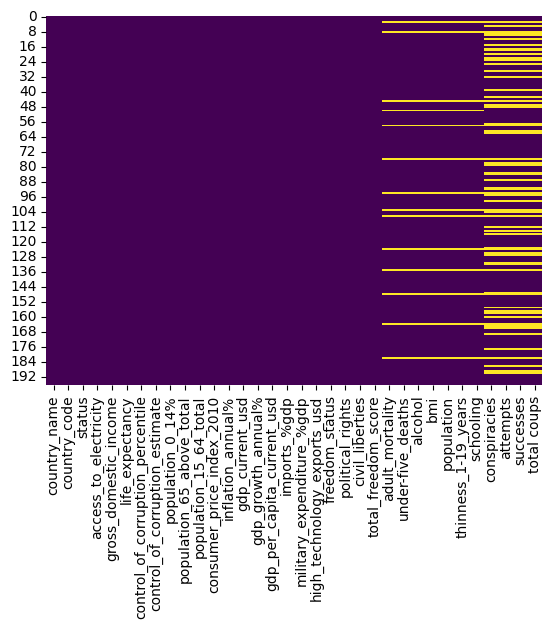

In [ ]:
sns.heatmap(cs_df.isnull(), cbar=False, cmap='viridis')

In [ ]:
# Check missing value
cs_df.isnull().sum()

,0
country_name,0
country_code,0
status,0
access_to_electricity,0
gross_domestic_income,0
life_expectancy,0
control_of_corruption_percentile,0
control_of_corruption_estimate,0
population_0_14%,0
population_65_above_total,0


In [ ]:
cs_df.columns

Index(['country_name', 'country_code', 'status', 'access_to_electricity',
       'gross_domestic_income', 'life_expectancy',
       'control_of_corruption_percentile', 'control_of_corruption_estimate',
       'population_0_14%', 'population_65_above_total',
       'population_15_64_total', 'consumer_price_index_2010',
       'inflation_annual%', 'gdp_current_usd', 'gdp_growth_annual%',
       'gdp_per_capita_current_usd', 'imports_%gdp',
       'military_expenditure_%gdp', 'high_technology_exports_usd',
       'freedom_status', 'political_rights', 'civil_liberties',
       'total_freedom_score', 'adult_mortality', 'under-five_deaths',
       'alcohol', 'bmi', 'population', 'thinness_1-19_years', 'schooling',
       'conspiracies', 'attempts', 'successes', 'total coups'],
      dtype='object')

In [ ]:
# Fill missing value for coup_df
cs_df[['conspiracies','attempts','successes','total coups']].fillna(0, inplace=True)

<ipython-input-14-d3743346125f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cs_df[['conspiracies','attempts','successes','total coups']].fillna(0, inplace=True)


In [ ]:
# Fil missing value based on Freedom status column for the rest of columns
for col_name in cs_df.columns:
    if col_name not in ['country_name', 'country_code', 'status','freedom_status']:
        # Calculate the median values for each status
        median_status_not_free = cs_df[cs_df['freedom_status'] == 'Not Free'][col_name].median()
        median_status_pa_free = cs_df[cs_df['freedom_status'] == 'Partly Free'][col_name].median()
        median_status_free = cs_df[cs_df['freedom_status'] == 'Free'][col_name].median()
        # Fill NaN values based on the 'status' column
        cs_df[col_name] = cs_df.apply(
            lambda row: (median_status_not_free if pd.isna(row[col_name]) and row['freedom_status'] == 'Not Free' else
                         (median_status_pa_free if pd.isna(row[col_name]) and row['freedom_status'] == 'Partly Free' else
                          median_status_free if pd.isna(row[col_name]) and row['freedom_status'] == 'Free' else
                          row[col_name])),
            axis=1
        )

In [ ]:
cs_df.isnull().sum()

,0
country_name,0
country_code,0
status,0
access_to_electricity,0
gross_domestic_income,0
life_expectancy,0
control_of_corruption_percentile,0
control_of_corruption_estimate,0
population_0_14%,0
population_65_above_total,0


In [ ]:
# Check cs_df datatypes
cs_df.dtypes

,0
country_name,object
country_code,object
status,float64
access_to_electricity,float64
gross_domestic_income,float64
life_expectancy,float64
control_of_corruption_percentile,float64
control_of_corruption_estimate,float64
population_0_14%,float64
population_65_above_total,int64


In [ ]:
cs_df.columns

Index(['country_name', 'country_code', 'status', 'access_to_electricity',
       'gross_domestic_income', 'life_expectancy',
       'control_of_corruption_percentile', 'control_of_corruption_estimate',
       'population_0_14%', 'population_65_above_total',
       'population_15_64_total', 'consumer_price_index_2010',
       'inflation_annual%', 'gdp_current_usd', 'gdp_growth_annual%',
       'gdp_per_capita_current_usd', 'imports_%gdp',
       'military_expenditure_%gdp', 'high_technology_exports_usd',
       'freedom_status', 'political_rights', 'civil_liberties',
       'total_freedom_score', 'adult_mortality', 'under-five_deaths',
       'alcohol', 'bmi', 'population', 'thinness_1-19_years', 'schooling',
       'conspiracies', 'attempts', 'successes', 'total coups'],
      dtype='object')

## Standard Scaler Cs

In [ ]:
# Select the columns to scale
columns_to_scale = [ 'access_to_electricity',
       'gross_domestic_income', 'life_expectancy',
       'control_of_corruption_percentile', 'control_of_corruption_estimate',
       'population_0_14%', 'population_65_above_total',
       'population_15_64_total', 'consumer_price_index_2010',
       'inflation_annual%', 'gdp_current_usd', 'gdp_growth_annual%',
       'gdp_per_capita_current_usd', 'imports_%gdp',
       'military_expenditure_%gdp', 'high_technology_exports_usd',
       'political_rights', 'civil_liberties',
       'total_freedom_score', 'adult_mortality', 'under-five_deaths',
       'alcohol', 'bmi', 'population', 'thinness_1-19_years', 'schooling']

scaler = MinMaxScaler()


scale_cs_df = cs_df.copy()
scale_cs_df[columns_to_scale] = scaler.fit_transform(cs_df[columns_to_scale])

# Display the scaled DataFrame
scale_cs_df.head()


,country_name,country_code,status,access_to_electricity,gross_domestic_income,life_expectancy,control_of_corruption_percentile,control_of_corruption_estimate,population_0_14%,population_65_above_total,...,under-five_deaths,alcohol,bmi,population,thinness_1-19_years,schooling,conspiracies,attempts,successes,total coups
0,Afghanistan,AFG,0.0,0.839520,0.000068,0.305127,0.1226,0.159624,0.846567,0.005080,...,0.071667,0.000000,0.221039,0.000253,0.651685,0.329032,1.0,2.0,9.0,12.0
1,Albania,ALB,0.0,1.000000,0.000119,0.735948,0.3868,0.340376,0.122854,0.002386,...,0.000833,0.296443,0.735020,0.000223,0.041199,0.600000,1.0,1.0,0.0,2.0
2,Algeria,DZA,0.0,1.000000,0.001772,0.745213,0.2830,0.286385,0.511534,0.014800,...,0.020000,0.000000,0.750999,0.030230,0.220974,0.612903,0.0,2.0,7.0,9.0
3,Andorra,AND,0.0,1.000000,0.000090,0.619055,0.8868,0.734742,0.032994,0.000060,...,0.000000,0.480237,0.750999,0.001127,0.052434,0.664516,1.0,1.0,2.0,3.5
4,Angola,AGO,0.0,0.437773,0.000099,0.275788,0.3066,0.295775,0.897264,0.004773,...,0.084167,0.548090,0.275632,0.002081,0.314607,0.419355,0.0,1.0,1.0,2.0


In [ ]:
cs_df.head(3)

,country_name,country_code,status,access_to_electricity,gross_domestic_income,life_expectancy,control_of_corruption_percentile,control_of_corruption_estimate,population_0_14%,population_65_above_total,...,under-five_deaths,alcohol,bmi,population,thinness_1-19_years,schooling,conspiracies,attempts,successes,total coups
0,Afghanistan,AFG,0.0,85.3,1.010000e+12,62.88,12.26,-1.18,43.13,984763,...,86.0,0.01,18.6,327582.0,17.5,10.0,1.0,2.0,9.0,12.0
1,Albania,ALB,0.0,100.0,1.770000e+12,76.83,38.68,-0.41,16.15,462629,...,1.0,4.51,57.2,288914.0,1.2,14.2,1.0,1.0,0.0,2.0
2,Algeria,DZA,0.0,100.0,2.640000e+13,77.13,28.30,-0.64,30.64,2868322,...,24.0,0.01,58.4,39113313.0,6.0,14.4,0.0,2.0,7.0,9.0


In [ ]:
cs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   country_name                      197 non-null    object 
 1   country_code                      197 non-null    object 
 2   status                            197 non-null    float64
 3   access_to_electricity             197 non-null    float64
 4   gross_domestic_income             197 non-null    float64
 5   life_expectancy                   197 non-null    float64
 6   control_of_corruption_percentile  197 non-null    float64
 7   control_of_corruption_estimate    197 non-null    float64
 8   population_0_14%                  197 non-null    float64
 9   population_65_above_total         197 non-null    int64  
 10  population_15_64_total            197 non-null    int64  
 11  consumer_price_index_2010         197 non-null    float64
 12  inflatio

In [ ]:
cs_df.describe()

,status,access_to_electricity,gross_domestic_income,life_expectancy,control_of_corruption_percentile,control_of_corruption_estimate,population_0_14%,population_65_above_total,population_15_64_total,consumer_price_index_2010,...,under-five_deaths,alcohol,bmi,population,thinness_1-19_years,schooling,conspiracies,attempts,successes,total coups
count,197.000000,197.000000,1.970000e+02,197.000000,197.000000,197.000000,197.000000,1.970000e+02,1.970000e+02,197.000000,...,197.000000,197.000000,197.000000,1.970000e+02,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000
mean,0.177665,86.227411,1.936094e+14,71.868376,47.799543,-0.070457,26.827919,3.937126e+06,2.618725e+07,551.908680,...,31.073604,3.356041,41.324365,1.561282e+07,4.472081,13.006345,1.350254,2.142132,2.984772,6.370558
std,0.383204,23.868059,1.411314e+15,7.638415,29.238734,1.009812,10.422277,1.634235e+07,1.004368e+08,3214.348307,...,110.382965,4.123971,20.832344,9.554366e+07,4.076836,2.817868,1.371787,2.563500,2.767297,5.585353
min,0.000000,8.400000,2.233758e+08,53.000000,0.000000,-1.860000,11.570000,3.110000e+02,6.999000e+03,102.220000,...,0.000000,0.010000,2.000000,4.100000e+01,0.100000,4.900000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,78.000000,2.260000e+11,65.990000,22.640000,-0.800000,17.200000,1.021500e+05,1.210748e+06,129.440000,...,0.000000,0.010000,23.700000,6.789140e+05,1.500000,11.100000,1.000000,1.000000,1.000000,3.000000
50%,0.000000,100.000000,1.710000e+12,72.980000,46.230000,-0.280000,25.420000,5.423430e+05,5.760782e+06,145.970000,...,3.000000,0.400000,47.700000,1.458734e+06,3.300000,13.000000,1.000000,1.000000,2.000000,4.000000
75%,0.000000,100.000000,4.590000e+12,77.580000,71.700000,0.600000,36.270000,1.929641e+06,1.808896e+07,182.180000,...,20.000000,7.300000,59.400000,4.238389e+06,6.400000,15.200000,2.000000,2.000000,4.000000,9.000000
max,1.000000,100.000000,1.490000e+16,85.380000,100.000000,2.400000,48.850000,1.937834e+08,9.748389e+08,38796.560000,...,1200.000000,15.190000,77.100000,1.293859e+09,26.800000,20.400000,11.000000,17.000000,17.000000,38.000000


# rescale_cs_df

In [ ]:
rescale_cs_df = cs_df.copy()

# Columns to be rescaled
columns_to_rescale = [
    'access_to_electricity', 'gross_domestic_income', 'life_expectancy',
    'control_of_corruption_percentile', 'control_of_corruption_estimate',
    'population_0_14%', 'population_65_above_total', 'population_15_64_total',
    'consumer_price_index_2010', 'inflation_annual%', 'gdp_current_usd',
    'gdp_growth_annual%', 'gdp_per_capita_current_usd', 'imports_%gdp',
    'military_expenditure_%gdp', 'high_technology_exports_usd',
    'political_rights', 'civil_liberties', 'total_freedom_score',
    'adult_mortality', 'under-five_deaths', 'alcohol', 'bmi', 'population',
    'thinness_1-19_years', 'schooling'
]

# Applying StandardScaler
scaler = StandardScaler()
rescale_cs_df[columns_to_rescale] = scaler.fit_transform(rescale_cs_df[columns_to_rescale])

# Display the first few rows of the rescaled DataFrame to verify
rescale_cs_df.head()


,country_name,country_code,status,access_to_electricity,gross_domestic_income,life_expectancy,control_of_corruption_percentile,control_of_corruption_estimate,population_0_14%,population_65_above_total,...,under-five_deaths,alcohol,bmi,population,thinness_1-19_years,schooling,conspiracies,attempts,successes,total coups
0,Afghanistan,AFG,0.0,-0.038955,-0.136816,-1.179731,-1.218592,-1.101561,1.568142,-0.181117,...,0.498866,-0.813431,-1.093601,-0.160389,3.203737,-1.069605,1.0,2.0,9.0,12.0
1,Albania,ALB,0.0,0.578500,-0.136276,0.651217,-0.312694,-0.337101,-1.027139,-0.213149,...,-0.273142,0.280530,0.764008,-0.160795,-0.804648,0.424681,1.0,1.0,0.0,2.0
2,Algeria,DZA,0.0,0.578500,-0.118780,0.690592,-0.668607,-0.565446,0.366695,-0.065568,...,-0.064246,-0.813431,0.821758,0.246593,0.375735,0.495838,0.0,2.0,7.0,9.0
3,Andorra,AND,0.0,0.578500,-0.136585,0.154433,1.401723,1.330814,-1.349384,-0.240796,...,-0.282224,0.958786,0.821758,-0.148520,-0.730874,0.780464,1.0,1.0,2.0,3.5
4,Angola,AGO,0.0,-1.584692,-0.136489,-1.304419,-0.587687,-0.525734,1.749947,-0.184763,...,0.635103,1.209182,-0.896290,-0.135574,0.990518,-0.571509,0.0,1.0,1.0,2.0


# Data Visualization

<ipython-input-24-d9deb674aef5>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='status', data=cs_df, palette=['blue', '#e76229'])


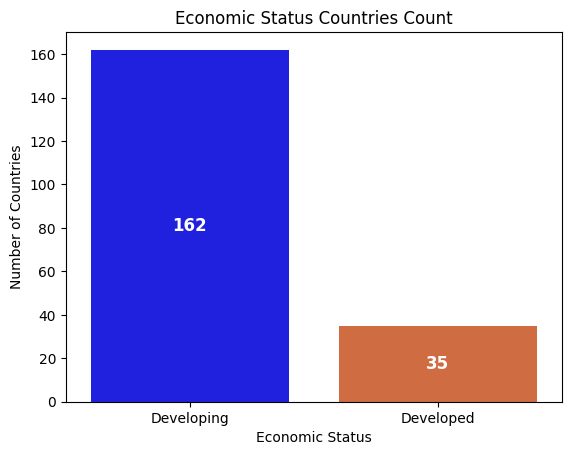

In [ ]:
sns.countplot(x='status', data=cs_df, palette=['blue', '#e76229'])

# Add title and labels
plt.title('Economic Status Countries Count')
plt.xlabel('Economic Status')
plt.ylabel('Number of Countries')

# Customize the x-axis labels
plt.xticks(ticks=[0, 1], labels=['Developing', 'Developed'])

# Add value annotations inside the bars with white font
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}',
                       (p.get_x() + p.get_width() / 2, p.get_height() / 2),
                       ha='center', va='center', color='white', fontsize=12, fontweight='bold')

# Show the plot
plt.show()


In [ ]:
# Exclude the first two columns
columns = cs_df.columns[2:]

# Determine the grid size dynamically based on the number of columns
num_columns = len(columns)
rows = (num_columns // 5) + int(num_columns % 5 != 0)
cols = 5

# Create a grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the columns and corresponding axes
for i, col in enumerate(columns):
    sns.histplot(cs_df[col], ax=axes[i])
    axes[i].set_title(col)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [ ]:
# Determine the number of columns to plot
columns_to_plot = cs_df.columns[3:]

# Create a 4x5 subplot grid (adjust the size as needed)
fig, axes = plt.subplots(8, 4, figsize=(20, 40))

# Flatten the axes array for easier indexing
axes = axes.flatten()

for idx, col in enumerate(columns_to_plot):
    sns.barplot(
        x='status',
        y=col,
        data=cs_df,
        hue='status',
        estimator='mean',
        hue_order=[0, 1],  # Ensures the order in the legend matches the data
        ax=axes[idx]
    )

    # Set custom labels for the x-axis
    axes[idx].set_xticklabels(['Developing', 'Developed'])

    # Remove the legend
    axes[idx].legend_.remove()

    # Add title and labels
    axes[idx].set_title(f'Avg. {col} ')
    axes[idx].set_xlabel('Economic Status')
    axes[idx].set_ylabel(f'Avg. {col}')

# Remove any empty subplots (if there are fewer than 20 columns)
for j in range(len(columns_to_plot), 20):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
columns_to_plot = cs_df.columns[3:]

palette = {'Not Free': 'red', 'Partly Free': 'orange', 'Free': 'green'}

fig, axes = plt.subplots(8, 4, figsize=(20, 40))

# Flatten the axes array for easier indexing
axes = axes.flatten()

for idx, col in enumerate(columns_to_plot):
    sns.barplot(
        x='freedom_status',
        y=col,
        data=cs_df,
        hue='freedom_status',
        estimator='mean',
        hue_order=['Not Free', 'Partly Free', 'Free'],
        palette=palette,
        ax=axes[idx],
        legend=False
    )

    # Add title and labels
    axes[idx].set_title(f'Avg. {col}')
    axes[idx].set_xlabel('Freedom Status')
    axes[idx].set_ylabel(f'Avg. {col}')


handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels, title='Freedom Status')

for j in range(len(columns_to_plot), 20):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()


In [ ]:
columns_to_plot = cs_df.columns[3:]

# Create a 4x5 subplot grid (adjust the size as needed)
fig, axes = plt.subplots(8, 4, figsize=(20, 40))

# Flatten the axes array for easier indexing
axes = axes.flatten()

for idx, col in enumerate(columns_to_plot):
    sns.barplot(
        x='status',
        y=col,
        data=cs_df,
        hue='status',
        estimator='mean',
        hue_order=[0, 1],  # Ensures the order in the legend matches the data
        ax=axes[idx]
    )

    # Set custom labels for the x-axis
    axes[idx].set_xticklabels(['Developing', 'Developed'])

    # Remove the legend
    axes[idx].legend_.remove()

    # Add title and labels
    axes[idx].set_title(f'Avg. {col} by Eco Status')
    axes[idx].set_xlabel('Economic Status')
    axes[idx].set_ylabel(f'Average {col}')

# Remove any empty subplots (if there are fewer than 20 columns)
for j in range(len(columns_to_plot), 20):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Correlation Heatmap
columns_to_exclude = ['country_name', 'country_code', 'freedom_status','status']
df_numeric = cs_df.drop(columns=columns_to_exclude)

# Calculate the correlation matrix for the remaining columns
correlation_matrix = df_numeric.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='rocket')

plt.show()


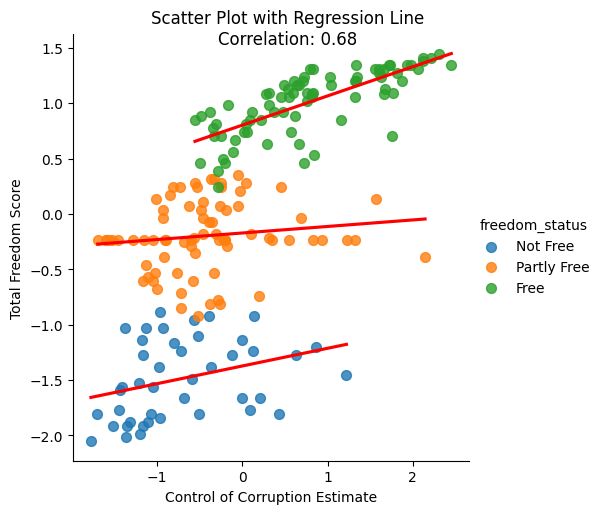

In [ ]:
# Create the scatter plot with a regression line and hue
sns.lmplot(x='control_of_corruption_estimate', y='total_freedom_score', data=rescale_cs_df, hue='freedom_status',
           scatter_kws={'s':50}, line_kws={'color':'red'}, ci=None)

# Calculate the correlation coefficient
corr = np.corrcoef(rescale_cs_df['control_of_corruption_estimate'], rescale_cs_df['total_freedom_score'])[0, 1]

# Annotate the plot with the correlation coefficient
plt.suptitle(f'Scatter Plot with Regression Line\nCorrelation: {corr:.2f}', y=1.02)
plt.xlabel('Control of Corruption Estimate')
plt.ylabel('Total Freedom Score')

plt.show()


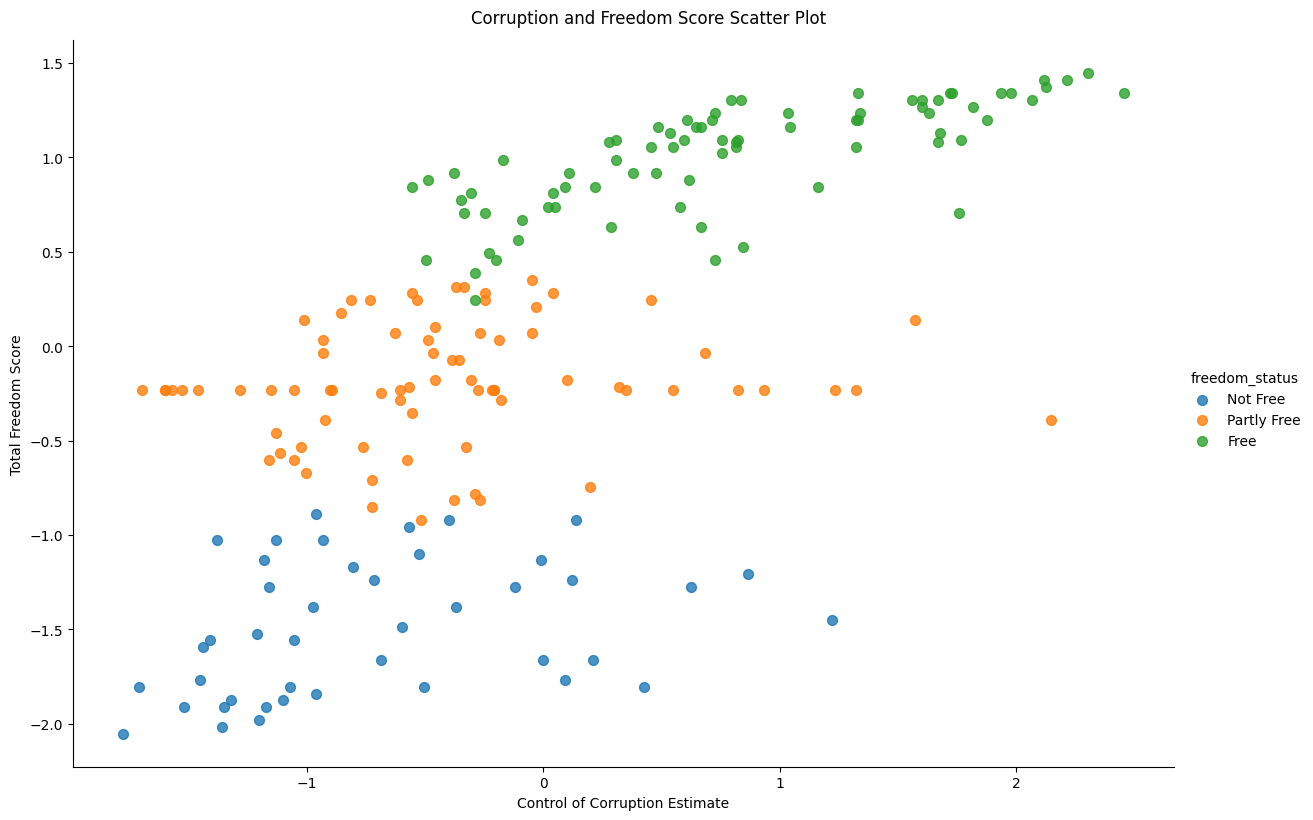

In [ ]:
sns.lmplot(
    x='control_of_corruption_estimate',
    y='total_freedom_score',
    data=rescale_cs_df,
    hue='freedom_status',
    scatter_kws={'s': 50},
    fit_reg=False,  # Disable the regression line
    height=8,      # Increase the height of the plot
    aspect=1.5      # Increase the aspect ratio to make the plot wider
)

# Add titles and labels
plt.suptitle('Corruption and Freedom Score Scatter Plot', y=1.02)
plt.xlabel('Control of Corruption Estimate')
plt.ylabel('Total Freedom Score')

# Display the plot
plt.show()



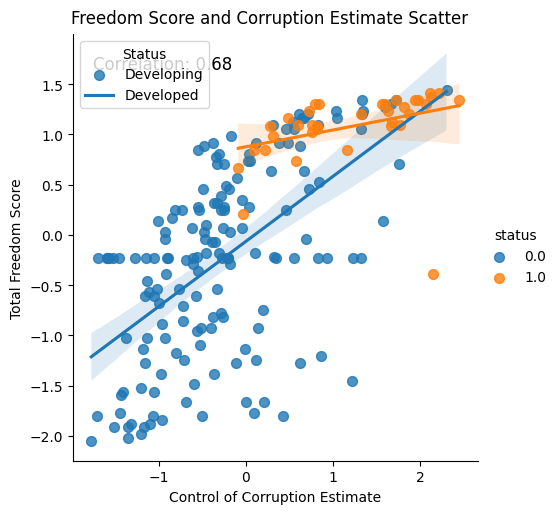

In [ ]:
plot = sns.lmplot(
    x='control_of_corruption_estimate',
    y='total_freedom_score',
    data=rescale_cs_df,
    hue='status',
    scatter_kws={'s': 50},
    fit_reg=True  # Enable the regression line
)

# Calculate the correlation coefficient
corr_coef = rescale_cs_df[['control_of_corruption_estimate', 'total_freedom_score']].corr().iloc[0, 1]

# Add titles and labels
plt.suptitle('Freedom Score and Corruption Estimate Scatter', y=1.02)
plt.xlabel('Control of Corruption Estimate')
plt.ylabel('Total Freedom Score')

# Customize the legend
plt.legend(title='Status', labels=['Developing', 'Developed'], loc='best')

# Add correlation coefficient text
plt.text(
    x=0.05,  # Adjust the x position
    y=0.95,  # Adjust the y position
    s=f'Correlation: {corr_coef:.2f}',
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top'
)

# Display the plot
plt.show()

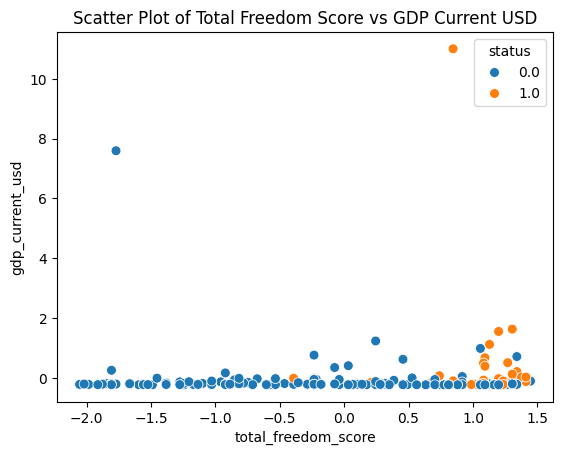

In [ ]:
x = 'total_freedom_score'
y = 'gdp_current_usd'

# Create the scatter plot with hue
sns.scatterplot(x=x, y=y, data=rescale_cs_df, hue='status', s=50)

# Set plot title and labels
plt.title('Scatter Plot of Total Freedom Score vs GDP Current USD')
plt.xlabel(x)
plt.ylabel(y)

# Show the plot
plt.show()

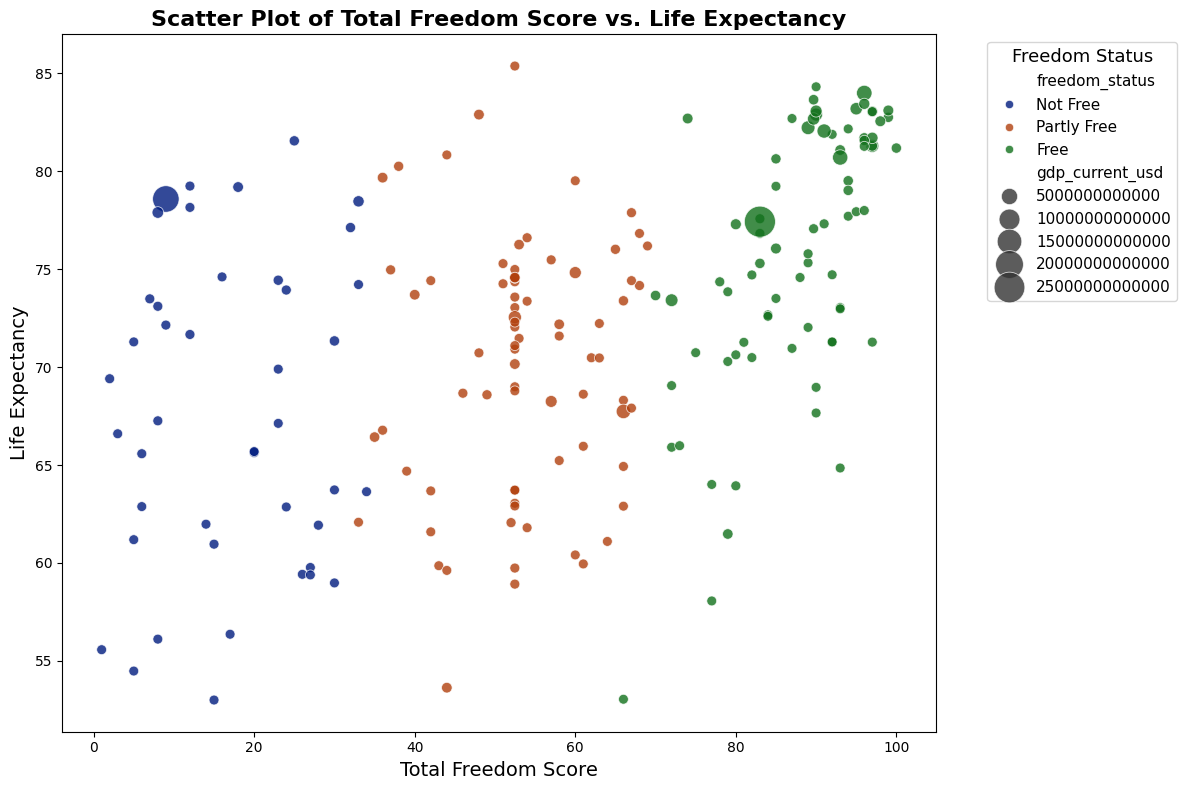

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot with increased marker size and high-contrast colors
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='total_freedom_score',
    y='life_expectancy',
    data=cs_df,
    hue='freedom_status',  # Color by 'freedom_status'
    palette='dark',  # Use a high-contrast color palette
    size='gdp_current_usd',  # Size of markers proportional to gdp_current_usd
    sizes=(50, 500),  # Increase the range of marker sizes
    alpha=0.8  # Increase transparency for better visibility
)

# Add title and labels
plt.title('Scatter Plot of Total Freedom Score vs. Life Expectancy', fontsize=16, fontweight='bold')
plt.xlabel('Total Freedom Score', fontsize=14)
plt.ylabel('Life Expectancy', fontsize=14)

# Adjust legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Freedom Status', title_fontsize='13', fontsize='11')

# Adjust layout to fit everything in the figure
plt.tight_layout()

# Show the plot
plt.show()


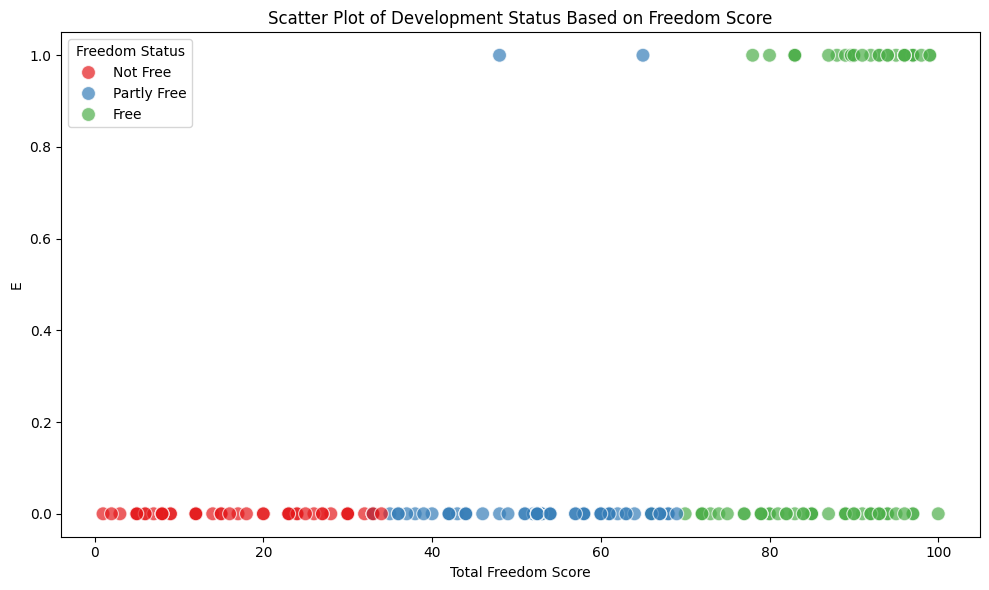

In [ ]:
X = cs_df[['total_freedom_score']]
y = cs_df['status']
hue = cs_df['freedom_status']

# Standardize the features (optional, only if you are using standardized features later)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the logistic regression model (optional, if not used later)
model = LogisticRegression()
model.fit(X_scaled, y)

# Plotting
plt.figure(figsize=(10, 6))

# Scatter plot with hue
sns.scatterplot(x='total_freedom_score', y='status', hue='freedom_status', data=cs_df,
                palette='Set1', s=100, alpha=0.7)  # Use contrasting colors
plt.grid(False)

plt.xlabel('Total Freedom Score')
plt.ylabel('E')
plt.title('Scatter Plot of Development Status Based on Freedom Score')
plt.legend(title='Freedom Status')


plt.tight_layout()
plt.show()

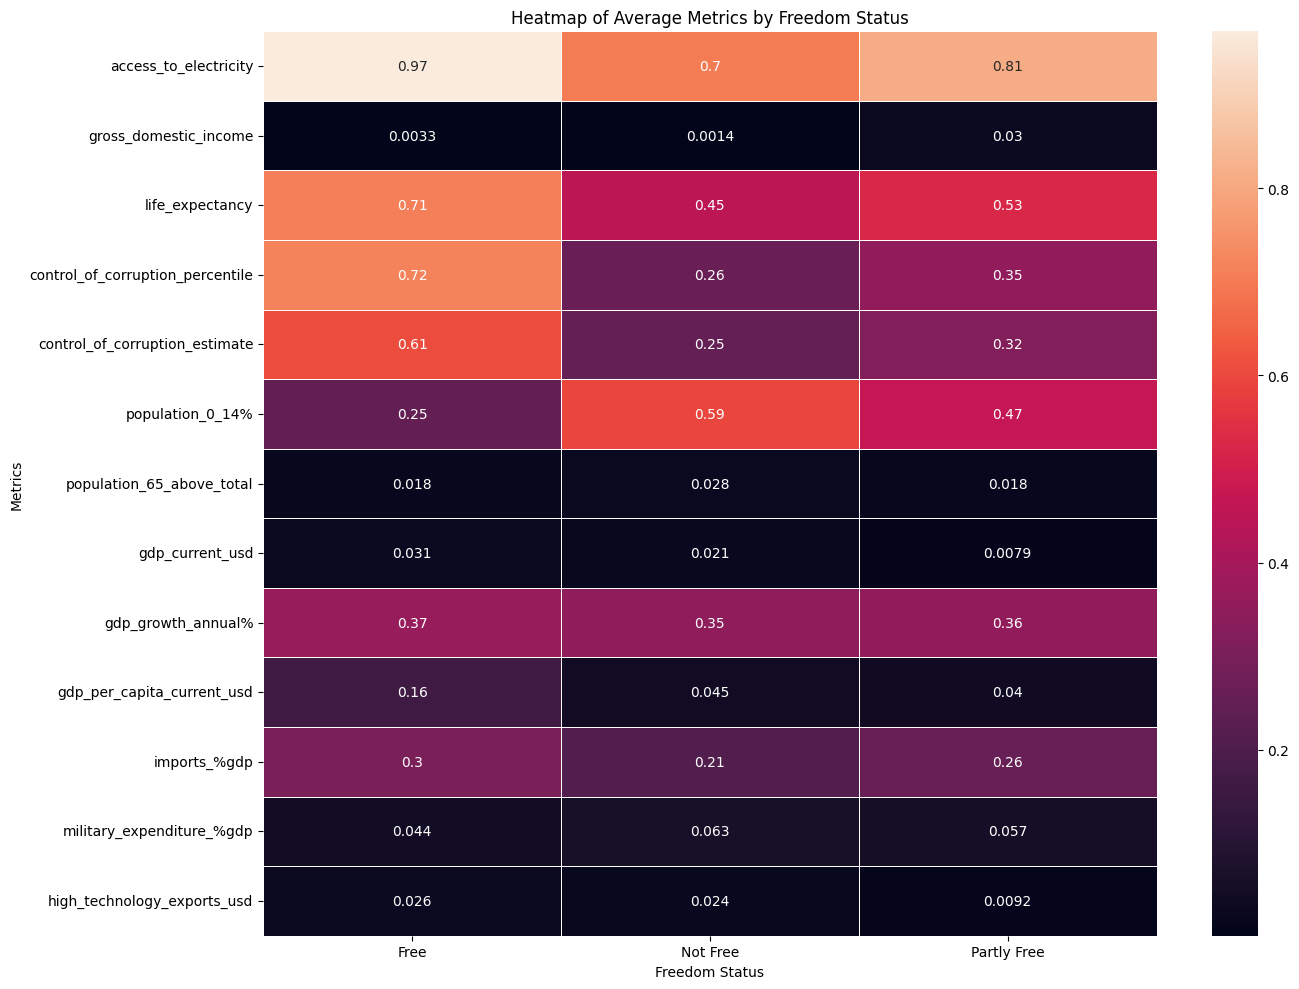

In [ ]:
columns_to_plot = [
    'access_to_electricity', 'gross_domestic_income', 'life_expectancy',
    'control_of_corruption_percentile', 'control_of_corruption_estimate',
    'population_0_14%', 'population_65_above_total', 'gdp_current_usd',
    'gdp_growth_annual%', 'gdp_per_capita_current_usd', 'imports_%gdp',
    'military_expenditure_%gdp', 'high_technology_exports_usd'
]

# Calculate the mean of each column grouped by 'freedom_status'
status_means = scale_cs_df.groupby('freedom_status')[columns_to_plot].mean()

# Transpose the DataFrame for easier plotting
status_means = status_means.T

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(status_means, annot=True, cmap="rocket", cbar=True, linewidths=0.5)

# Add title and labels
plt.title('Heatmap of Average Metrics by Freedom Status')
plt.xlabel('Freedom Status')
plt.ylabel('Metrics')

# Show the plot
plt.tight_layout()
plt.show()

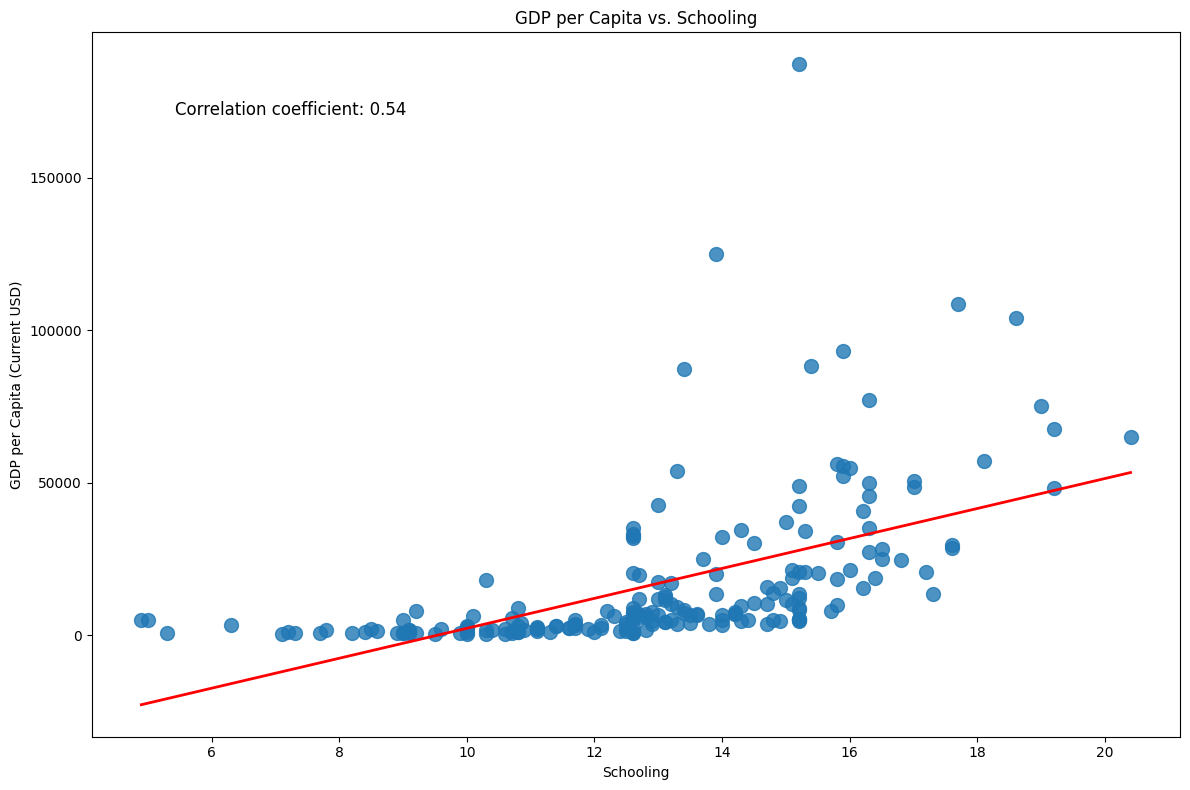

In [ ]:
# Scatter plot with regression line
plt.figure(figsize=(12, 8))

# Create scatter plot with regression line
sns.regplot(
    x='schooling',
    y='gdp_per_capita_current_usd',
    data=cs_df,
    scatter_kws={'s': 100, 'alpha': 0.8},  # Marker size and transparency
    line_kws={'color': 'red', 'lw': 2},  # Line color and width
    ci=None  # No confidence interval
)

# Add labels and title
plt.title('GDP per Capita vs. Schooling')
plt.xlabel('Schooling')
plt.ylabel('GDP per Capita (Current USD)')


# Calculate and display the correlation coefficient
corr = np.corrcoef(cs_df['schooling'], cs_df['gdp_per_capita_current_usd'])[0, 1]
plt.figtext(0.15, 0.85, f'Correlation coefficient: {corr:.2f}', fontsize=12, color='black')

plt.tight_layout()
plt.show()

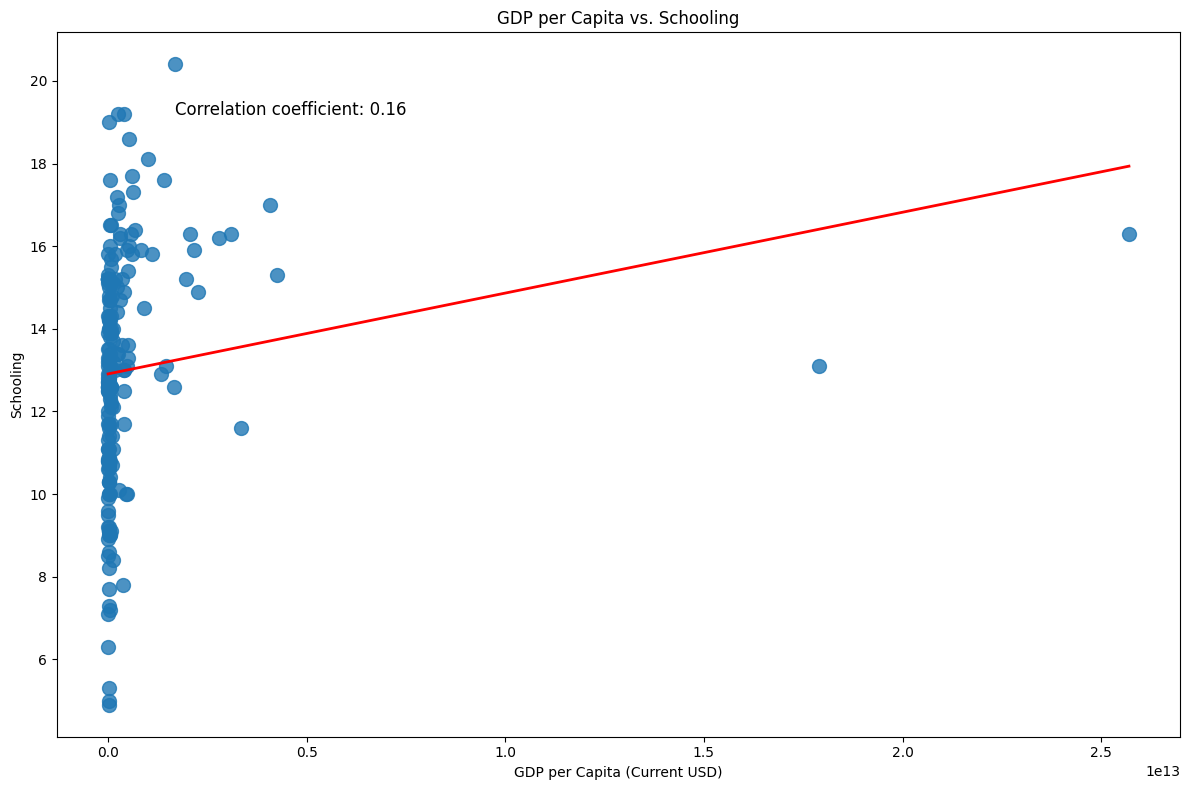

In [ ]:
# Scatter plot with regression line
plt.figure(figsize=(12, 8))

# Create scatter plot with regression line
sns.regplot(
    x='gdp_current_usd',
    y='schooling',
    data=cs_df,
    scatter_kws={'s': 100, 'alpha': 0.8},  # Marker size and transparency
    line_kws={'color': 'red', 'lw': 2},  # Line color and width
    ci=None  # No confidence interval
)

# Add labels and title
plt.title('GDP per Capita vs. Schooling')
plt.xlabel('GDP per Capita (Current USD)')
plt.ylabel('Schooling')


# Calculate and display the correlation coefficient
corr = np.corrcoef(cs_df['gdp_current_usd'], cs_df['schooling'])[0, 1]
plt.figtext(0.15, 0.85, f'Correlation coefficient: {corr:.2f}', fontsize=12, color='black')

plt.tight_layout()
plt.show()

In [ ]:
cs_df.columns

Index(['country_name', 'country_code', 'status', 'access_to_electricity',
       'gross_domestic_income', 'life_expectancy',
       'control_of_corruption_percentile', 'control_of_corruption_estimate',
       'population_0_14%', 'population_65_above_total',
       'population_15_64_total', 'consumer_price_index_2010',
       'inflation_annual%', 'gdp_current_usd', 'gdp_growth_annual%',
       'gdp_per_capita_current_usd', 'imports_%gdp',
       'military_expenditure_%gdp', 'high_technology_exports_usd',
       'freedom_status', 'political_rights', 'civil_liberties',
       'total_freedom_score', 'adult_mortality', 'under-five_deaths',
       'alcohol', 'bmi', 'population', 'thinness_1-19_years', 'schooling',
       'conspiracies', 'attempts', 'successes', 'total coups'],
      dtype='object')

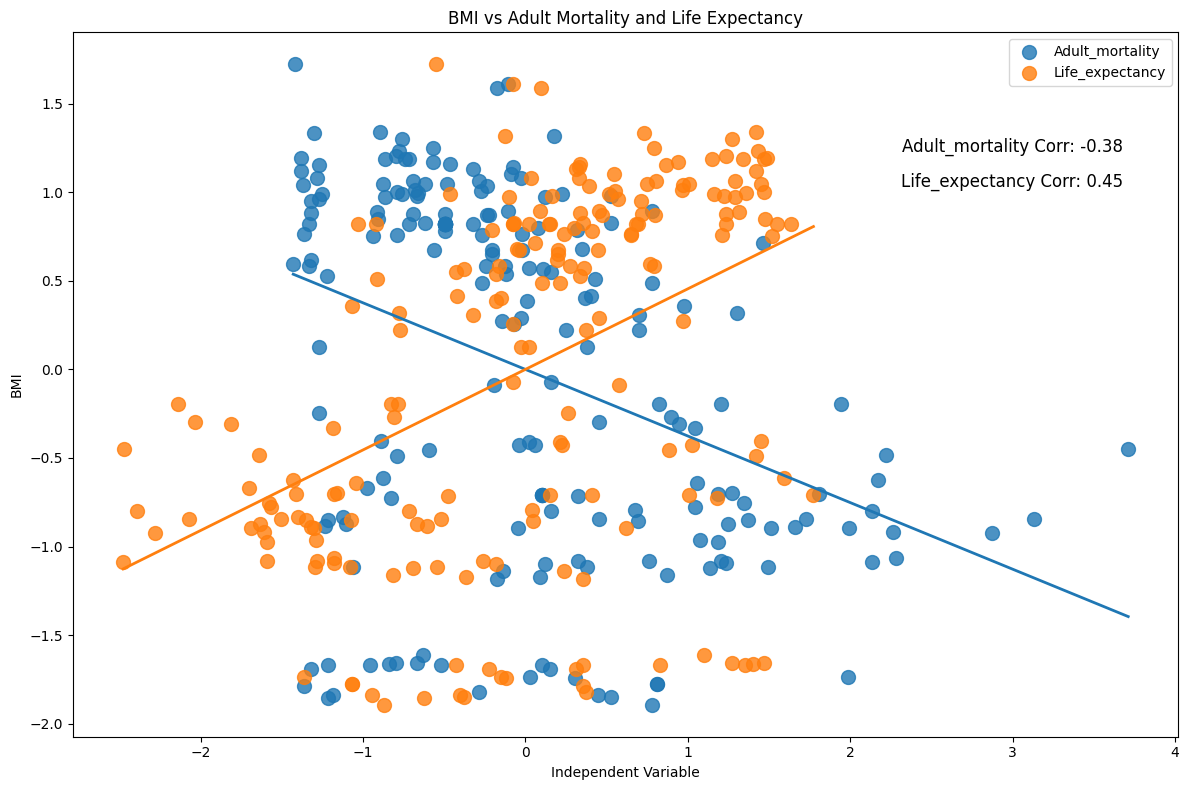

In [ ]:
plt.figure(figsize=(12, 8))

# Loop through each independent variable and plot on the same axes
for var in ['adult_mortality', 'life_expectancy']:
    sns.regplot(
        x=var,
        y='bmi',
        data=rescale_cs_df,
        scatter_kws={'s': 100, 'alpha': 0.8},
        line_kws={'lw': 2},
        ci=None,
        label=f'{var.capitalize()}'  # Add a label for the legend
    )

    # Calculate and display the correlation coefficient for the correct pair
    corr = np.corrcoef(rescale_cs_df[var], rescale_cs_df['bmi'])[0, 1]
    plt.text(
        0.95, 0.85 if var == 'adult_mortality' else 0.80,
        f'{var.capitalize()} Corr: {corr:.2f}',
        fontsize=12, color='black', transform=plt.gca().transAxes,
        ha='right', va='top'
    )

# Add labels and title
plt.title('BMI vs Adult Mortality and Life Expectancy')
plt.xlabel('Independent Variable')
plt.ylabel('BMI')

# Add legend
plt.legend()

plt.tight_layout()
plt.show()

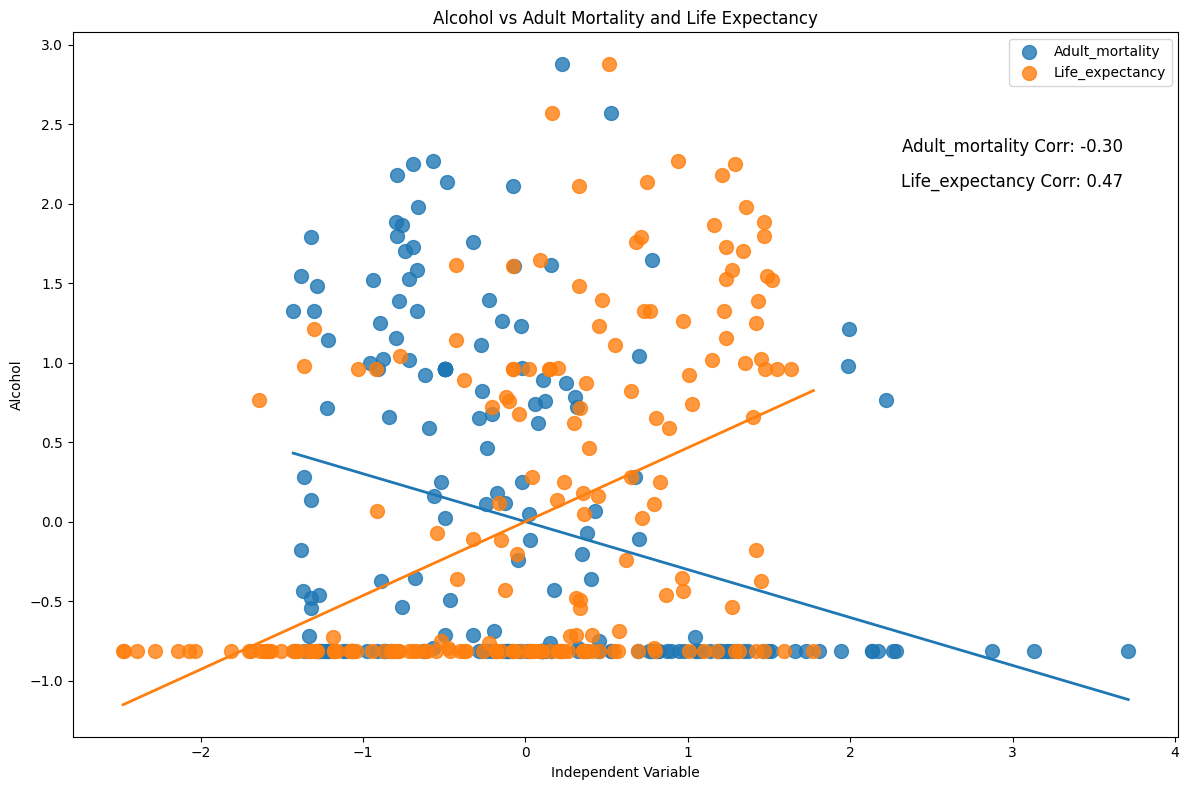

In [ ]:
plt.figure(figsize=(12, 8))

# Loop through each independent variable and plot on the same axes
for var in ['adult_mortality', 'life_expectancy']:
    sns.regplot(
        x=var,
        y='alcohol',
        data=rescale_cs_df,
        scatter_kws={'s': 100, 'alpha': 0.8},
        line_kws={'lw': 2},
        ci=None,
        label=f'{var.capitalize()}'  # Add a label for the legend
    )

    # Calculate and display the correlation coefficient for the correct pair
    corr = np.corrcoef(rescale_cs_df[var], rescale_cs_df['alcohol'])[0, 1]
    plt.text(
        0.95, 0.85 if var == 'adult_mortality' else 0.80,
        f'{var.capitalize()} Corr: {corr:.2f}',
        fontsize=12, color='black', transform=plt.gca().transAxes,
        ha='right', va='top'
    )

# Add labels and title
plt.title('Alcohol vs Adult Mortality and Life Expectancy')
plt.xlabel('Independent Variable')
plt.ylabel('Alcohol')

# Add legend
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Define dependent and independent variables
X = cs_df[['bmi', 'alcohol']]
Y = cs_df['adult_mortality']

# Standardize the independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add a constant for the intercept
X_scaled = sm.add_constant(X_scaled)

# Fit the multiple regression model
model = sm.OLS(Y, X_scaled).fit()
print(model.summary())

# Optionally, if you want to visualize, you could plot residuals or predictions


                            OLS Regression Results                            
Dep. Variable:        adult_mortality   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     19.42
Date:                Wed, 21 Aug 2024   Prob (F-statistic):           2.04e-08
Time:                        13:35:41   Log-Likelihood:                -1171.4
No. Observations:                 197   AIC:                             2349.
Df Residuals:                     194   BIC:                             2359.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        145.8655      6.641     21.963      0.0

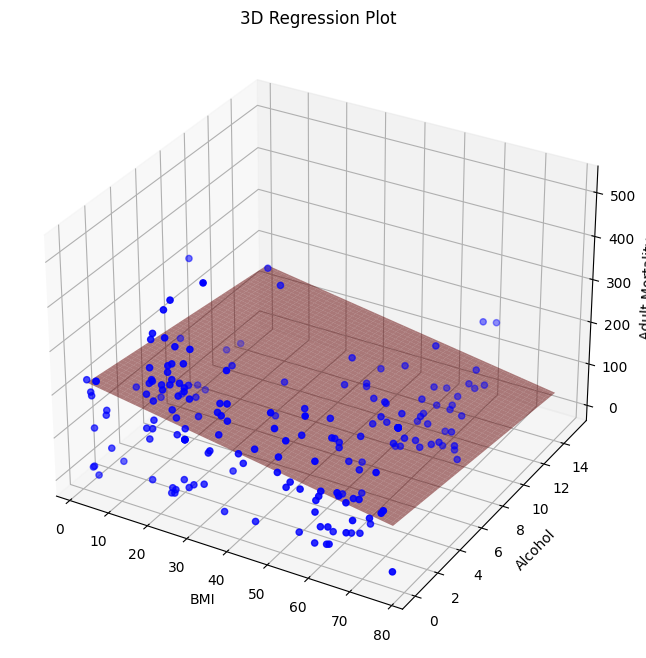

In [ ]:
# Fit the model using sklearn
lm = LinearRegression()
lm.fit(X, Y)
predictions = lm.predict(X)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of actual data
ax.scatter(cs_df['bmi'], cs_df['alcohol'], Y, color='blue', label='Actual Data')

# Create a mesh grid for predictions
bmi_range = np.linspace(X['bmi'].min(), X['bmi'].max(), 100)
alcohol_range = np.linspace(X['alcohol'].min(), X['alcohol'].max(), 100)
bmi_mesh, alcohol_mesh = np.meshgrid(bmi_range, alcohol_range)
X_mesh = pd.DataFrame({'bmi': bmi_mesh.ravel(), 'alcohol': alcohol_mesh.ravel()})
predictions_mesh = lm.predict(X_mesh).reshape(bmi_mesh.shape)

# Plot the regression surface
ax.plot_surface(bmi_mesh, alcohol_mesh, predictions_mesh, color='red', alpha=0.5)

ax.set_xlabel('BMI')
ax.set_ylabel('Alcohol')
ax.set_zlabel('Adult Mortality')
plt.title('3D Regression Plot')
plt.show()


In [ ]:
cs_df.columns

Index(['country_name', 'country_code', 'status', 'access_to_electricity',
       'gross_domestic_income', 'life_expectancy',
       'control_of_corruption_percentile', 'control_of_corruption_estimate',
       'population_0_14%', 'population_65_above_total',
       'population_15_64_total', 'consumer_price_index_2010',
       'inflation_annual%', 'gdp_current_usd', 'gdp_growth_annual%',
       'gdp_per_capita_current_usd', 'imports_%gdp',
       'military_expenditure_%gdp', 'high_technology_exports_usd',
       'freedom_status', 'political_rights', 'civil_liberties',
       'total_freedom_score', 'adult_mortality', 'under-five_deaths',
       'alcohol', 'bmi', 'population', 'thinness_1-19_years', 'schooling',
       'conspiracies', 'attempts', 'successes', 'total coups'],
      dtype='object')

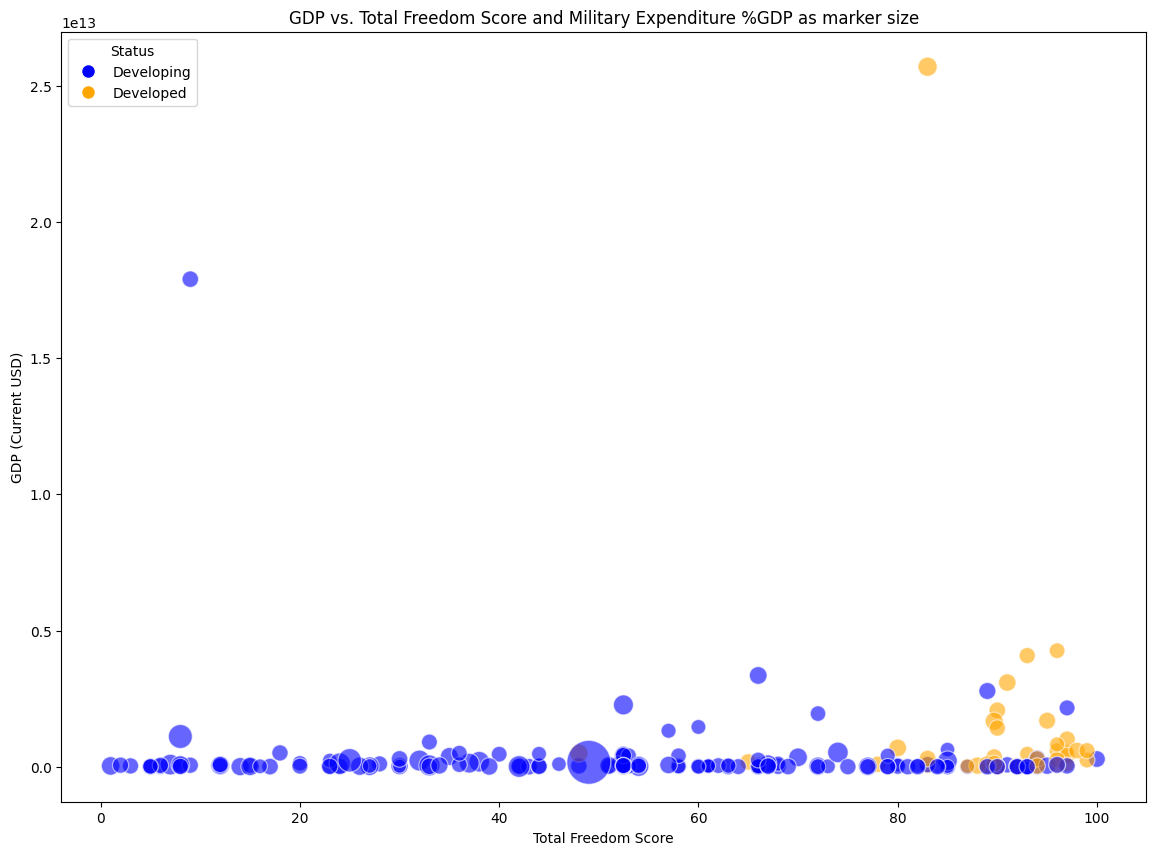

In [ ]:
x = cs_df['total_freedom_score']
y = cs_df['gdp_current_usd']
z = cs_df['military_expenditure_%gdp']
status = cs_df['status']

z_normalized = (z - z.min()) / (z.max() - z.min()) * 1000

custom_palette = ['blue', 'orange']

plt.figure(figsize=(14, 10))

scatter = sns.scatterplot(
    x=x,
    y=y,
    size=z_normalized,
    hue=status,
    palette=custom_palette,
    alpha=0.6,
    sizes=(100, 1000)
)

# Add custom legend
hue_labels = {0: 'Developing', 1: 'Developed'}
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=custom_palette[i], markersize=10, label=label) for i, label in hue_labels.items()]
plt.legend(handles=handles, title='Status', loc='upper left')

plt.xlabel('Total Freedom Score')
plt.ylabel('GDP (Current USD)')
plt.title('GDP vs. Total Freedom Score and Military Expenditure %GDP as marker size')

plt.show()


In [ ]:
cs_df.columns

Index(['country_name', 'country_code', 'status', 'access_to_electricity',
       'gross_domestic_income', 'life_expectancy',
       'control_of_corruption_percentile', 'control_of_corruption_estimate',
       'population_0_14%', 'population_65_above_total',
       'population_15_64_total', 'consumer_price_index_2010',
       'inflation_annual%', 'gdp_current_usd', 'gdp_growth_annual%',
       'gdp_per_capita_current_usd', 'imports_%gdp',
       'military_expenditure_%gdp', 'high_technology_exports_usd',
       'freedom_status', 'political_rights', 'civil_liberties',
       'total_freedom_score', 'adult_mortality', 'under-five_deaths',
       'alcohol', 'bmi', 'population', 'thinness_1-19_years', 'schooling',
       'conspiracies', 'attempts', 'successes', 'total coups'],
      dtype='object')

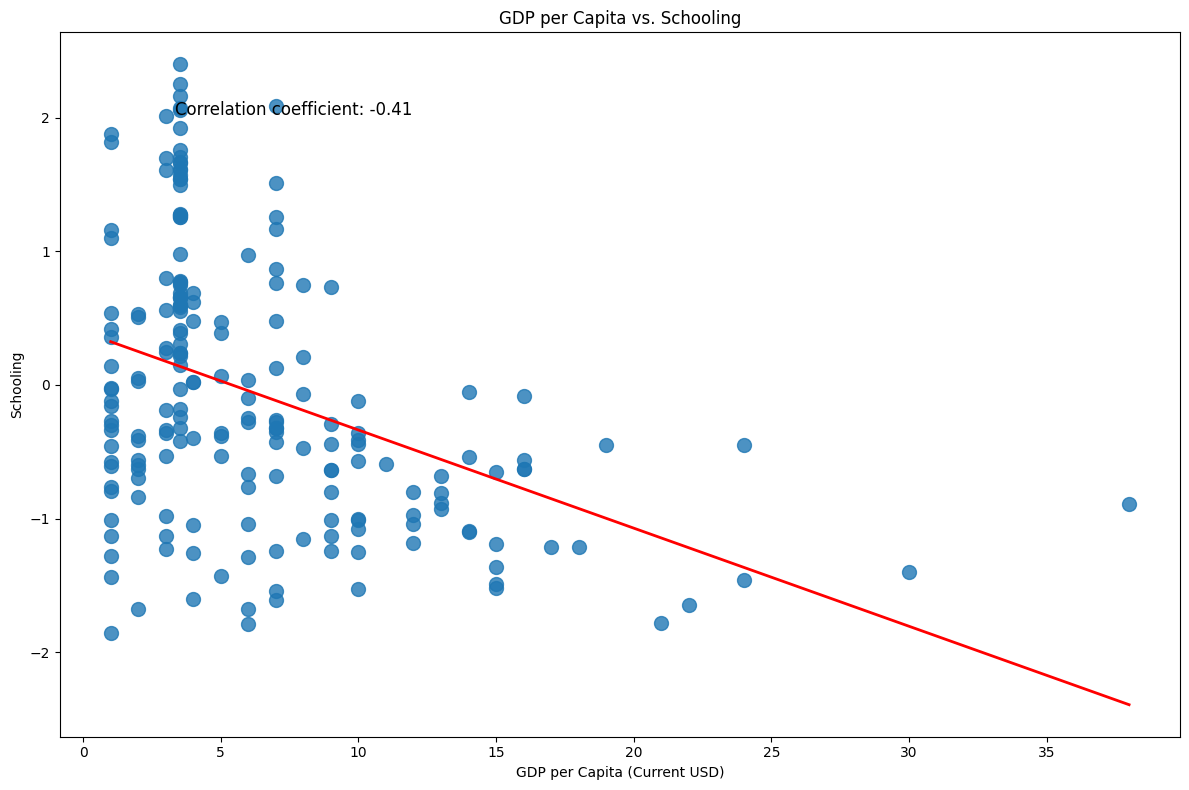

In [ ]:
# Scatter plot with regression line
plt.figure(figsize=(12, 8))

sns.regplot(
    x='total coups',
    y='control_of_corruption_estimate',
    data=cs_df,
    scatter_kws={'s': 100, 'alpha': 0.8},
    line_kws={'color': 'red', 'lw': 2},
    ci=None
)


plt.title('GDP per Capita vs. Schooling')
plt.xlabel('GDP per Capita (Current USD)')
plt.ylabel('Schooling')



corr = np.corrcoef(cs_df['total coups'], cs_df['control_of_corruption_estimate'])[0, 1]
plt.figtext(0.15, 0.85, f'Correlation coefficient: {corr:.2f}', fontsize=12, color='black')

plt.tight_layout()
plt.show()

In [ ]:
cs_df.columns

Index(['country_name', 'country_code', 'status', 'access_to_electricity',
       'gross_domestic_income', 'life_expectancy',
       'control_of_corruption_percentile', 'control_of_corruption_estimate',
       'population_0_14%', 'population_65_above_total',
       'population_15_64_total', 'consumer_price_index_2010',
       'inflation_annual%', 'gdp_current_usd', 'gdp_growth_annual%',
       'gdp_per_capita_current_usd', 'imports_%gdp',
       'military_expenditure_%gdp', 'high_technology_exports_usd',
       'freedom_status', 'political_rights', 'civil_liberties',
       'total_freedom_score', 'adult_mortality', 'under-five_deaths',
       'alcohol', 'bmi', 'population', 'thinness_1-19_years', 'schooling',
       'conspiracies', 'attempts', 'successes', 'total coups'],
      dtype='object')

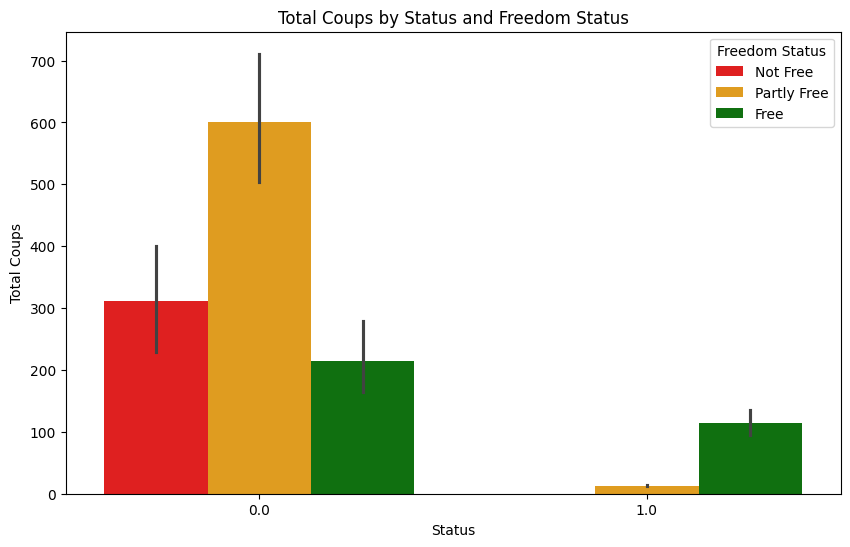

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

palette = {'Not Free': 'red', 'Partly Free': 'orange', 'Free': 'green'}

sns.barplot(
    x='status',
    y='total coups',
    data=cs_df,
    hue='freedom_status',
    estimator=sum,
    palette=palette,
    ax=ax
)

ax.set_title('Total Coups by Status and Freedom Status')
ax.set_xlabel('Status')
ax.set_ylabel('Total Coups')
ax.legend(title='Freedom Status')

plt.show()

<ipython-input-50-ae829cb4bb60>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), ha='center')


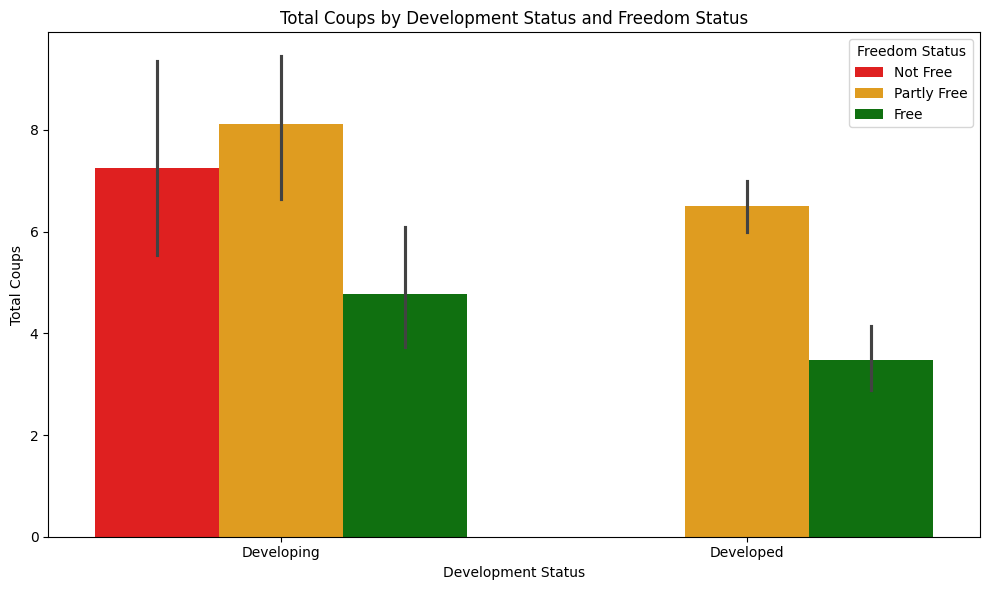

In [ ]:
status_mapping = {0: 'Developing', 1: 'Developed'}
cs_df['status_label'] = cs_df['status'].map(status_mapping)

fig, ax = plt.subplots(figsize=(10, 6))

palette = {'Not Free': 'red', 'Partly Free': 'orange', 'Free': 'green'}

sns.barplot(
    x='status_label',
    y='total coups',
    data=cs_df,
    hue='freedom_status',
    estimator='mean',
    palette=palette,
    ax=ax
)

ax.set_title('Total Coups by Development Status and Freedom Status')
ax.set_xlabel('Development Status')
ax.set_ylabel('Total Coups')
ax.legend(title='Freedom Status')

ax.set_xticklabels(ax.get_xticklabels(), ha='center')

plt.tight_layout()
plt.show()

In [ ]:
status_mapping = {0: 'Developing', 1: 'Developed'}
cs_df['status_label'] = cs_df['status'].map(status_mapping)

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(
    x='status_label',
    y='total coups',
    data=cs_df,
    estimator='mean',
    palette=['blue', '#e76229'],
    ax=ax
)

ax.set_title('Total Coups by Development Status')
ax.set_xlabel('Development Status')
ax.set_ylabel('Total Coups')

ax.set_xticklabels(ax.get_xticklabels(), ha='center')

plt.tight_layout()
plt.show()


In [ ]:
X = cs_df[['total coups']]
y = cs_df['status']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X_scaled, y)

# Plotting
plt.figure(figsize=(10, 6))

# Scatter plot with hue
sns.scatterplot(x='total coups', y='status', hue='status', data=cs_df,
                palette='Set1', s=100, alpha=0.7)

# Generate values for the logistic curve
X_range = np.linspace(X['total coups'].min(), X['total coups'].max(), 300)
X_range_scaled = scaler.transform(X_range.reshape(-1, 1))
y_prob = model.predict_proba(X_range_scaled)[:, 1]

# Plot the logistic curve
plt.plot(X_range, y_prob, color='blue', label='Logistic Regression Curve')

plt.grid(False)
plt.xlabel('Total Coups')
plt.ylabel('Status (0 = Developing, 1 = Developed)')
plt.title('Logistic Regression Curve with Scatter Plot')
plt.legend(title='Freedom Status')

plt.tight_layout()
plt.show()

In [ ]:
status_mapping = {0: 'Developing', 1: 'Developed'}
cs_df['status_label'] = cs_df['status'].map(status_mapping)

columns = ['conspiracies', 'attempts', 'successes', 'total coups']

for col in columns:
    fig, ax = plt.subplots(figsize=(10, 6))

    sns.barplot(
        x='status_label',
        y=col,
        data=cs_df,
        estimator='mean',
        palette=['blue', '#e76229'],
        ax=ax
    )

    ax.set_title(f'Total {col.capitalize()} by Development Status')
    ax.set_xlabel('Development Status')
    ax.set_ylabel(f'{col.capitalize()}')

    ax.set_xticklabels(ax.get_xticklabels(), ha='center')

    plt.tight_layout()

    # Save the figure as an image file
    plt.savefig(f'{col}_by_development_status.png')

    plt.show()

In [ ]:
# Rank percentitle
cs_df['rank'] = cs_df['values'].rank(pct=True) * 100

In [ ]:
cs_df.columns

In [ ]:
columns = ['control_of_corruption_estimate', 'gdp_current_usd', 'freedom_status', 'total coups']
cs_df_rank = pd.DataFrame(index=cs_df.index)
for col in columns:
    cs_df_rank[f'rank_{col}'] = cs_df[col].rank(pct=True) * 100

cs_df_rank['country_name'] = cs_df['country_name']
cs_df_rank['country_code'] = cs_df['country_code']
cs_df_rank = cs_df_rank[['country_name', 'country_code'] + [f'rank_{col}' for col in columns]]
cs_df_rank

In [ ]:
cs_df_rank[cs_df_rank['country_name'] == 'Thailand'].round(2)

In [ ]:
cs_df[cs_df['country_name'] == 'Thailand']

In [ ]:

plt.figure(figsize=(12, 8))

# Scatter plot with hue
sns.scatterplot(
    x='life_expectancy',
    y='total_freedom_score',
    hue='status',
    data=cs_df,
    s=100,
    alpha=0.8
)

# Regression line for the whole dataset
sns.regplot(
    x='life_expectancy',
    y='total_freedom_score',
    data=cs_df,
    scatter=False,
    line_kws={'color': 'red', 'lw': 2},
    ci=None
)

# Update the legend labels
plt.legend(
    title='Status',
    labels=['Developing', 'Developed']
)

# Add labels and title
plt.title('Life Expectancy vs. Total Freedom Score')
plt.xlabel('Life Expectancy')
plt.ylabel('Total Freedom Score')

# Calculate and display the correlation coefficient
corr = np.corrcoef(cs_df['life_expectancy'].dropna(), cs_df['total_freedom_score'].dropna())[0, 1]
plt.figtext(0.15, 0.85, f'Correlation coefficient: {corr:.2f}', fontsize=12, color='black')

plt.tight_layout()
plt.show()

In [ ]:
cs_df.columns